# Test 3

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


PyTorch version: 2.8.0+cu126
Using device: cuda


In [2]:
class Config:
    NUM_SAMPLES = 10000
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 500
    INPUT_SIZE = 4   # [x0, v0, a, t]
    OUTPUT_SIZE = 2  # [xf, vf]
    HIDDEN_SIZE = 32
    NUM_HIDDEN_LAYERS = 2

    # Simulation parameters for rollout
    SIM_STEPS = 50
    SIM_DT = 1.0
    SIM_X0 = 0.0
    SIM_V0 = 0.0
    SIM_A = 0.1

In [3]:
def generate_kinematic_data(num_samples):
    """Generates a synthetic dataset for 1D kinematics with constant acceleration."""
    # Input features: [initial_pos, initial_vel, acceleration, time]
    x0 = np.random.uniform(-10, 10, (num_samples, 1))
    v0 = np.random.uniform(-5, 5, (num_samples, 1))
    a = np.random.uniform(-2, 2, (num_samples, 1))
    t = np.random.uniform(0.1, 5.0, (num_samples, 1))

    inputs = np.hstack((x0, v0, a, t))

    # Target outputs: [final_pos, final_vel] based on kinematic equations
    xf = x0 + v0 * t + 0.5 * a * t**2
    vf = v0 + a * t

    targets = np.hstack((xf, vf))

    return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

class KinematicsDataset(Dataset):
    """Custom PyTorch Dataset for the kinematics data."""
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [5]:
# Model 1: Physics-Only Model (as a function)
def physics_only_model(inputs):
    """
    Applies the kinematic equations directly.
    inputs: tensor of shape (N, 4) -> [x0, v0, a, t]
    """
    x0, v0, a, t = inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3]
    xf = x0 + v0 * t + 0.5 * a * t**2
    vf = v0 + a * t
    return torch.stack((xf, vf), dim=1)

# Model 2: ANN-Only Model
class ANNOnlyModel(nn.Module):
    """A simple MLP to learn kinematics from scratch."""
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(ANNOnlyModel, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Model 3: Hybrid Residual Model (PHY+ANN)
class HybridModel(nn.Module):
    """Augments the physics model with a learned residual correction."""
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(HybridModel, self).__init__()
        # The ANN component learns the residual
        self.residual_net = ANNOnlyModel(input_size, hidden_size, output_size, num_hidden_layers)

    def forward(self, x):
        # Physics-based prediction
        phy_pred = physics_only_model(x)

        # Learned residual prediction
        residual = self.residual_net(x)

        # Final prediction is the sum
        return phy_pred + residual

In [7]:
def train_model(model, dataloader, num_epochs, learning_rate, model_name):
    """Generic training loop for a PyTorch model."""
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []
    print(f"\n--- Training {model_name} ---")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_epoch_loss)
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}")

    return loss_history

In [9]:
def rollout_trajectory(model, x0, v0, a, dt, n_steps, model_name):
    """
    Performs a multi-step trajectory rollout using a given model.
    This iterative prediction resembles the state-update loop in reinforcement learning.
    """
    print(f"\n--- Rolling out trajectory for {model_name} ---")
    model.eval()
    with torch.no_grad():
        current_x = x0
        current_v = v0

        trajectory = [(current_x, current_v)]

        for _ in range(n_steps):
            # Prepare input for the model: [current_pos, current_vel, accel, time_step]
            model_input = torch.tensor([[current_x, current_v, a, dt]], dtype=torch.float32).to(device)

            # Predict the next state
            next_state = model(model_input).squeeze().cpu().numpy()

            current_x, current_v = next_state[0], next_state[1]
            trajectory.append((current_x, current_v))

    return np.array(trajectory)

--- Generating Data ---
Dataset created with 8000 training samples and 2000 test samples.

--- Training ANN-Only Model ---
Epoch [50/500], Loss: 0.125328
Epoch [100/500], Loss: 0.045570
Epoch [150/500], Loss: 0.028712
Epoch [200/500], Loss: 0.023630
Epoch [250/500], Loss: 0.017981
Epoch [300/500], Loss: 0.016527
Epoch [350/500], Loss: 0.014050
Epoch [400/500], Loss: 0.012522
Epoch [450/500], Loss: 0.011781
Epoch [500/500], Loss: 0.009313

--- Training Hybrid Model ---
Epoch [50/500], Loss: 0.000003
Epoch [100/500], Loss: 0.000005
Epoch [150/500], Loss: 0.000000
Epoch [200/500], Loss: 0.000000
Epoch [250/500], Loss: 0.000000
Epoch [300/500], Loss: 0.000000
Epoch [350/500], Loss: 0.000000
Epoch [400/500], Loss: 0.000000
Epoch [450/500], Loss: 0.000000
Epoch [500/500], Loss: 0.000000


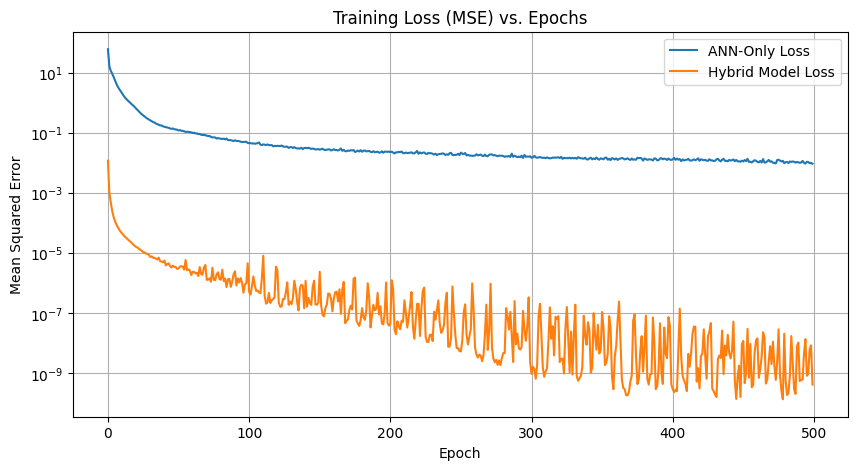


--- Rolling out trajectory for ANN-Only Model ---

--- Rolling out trajectory for Hybrid Model ---


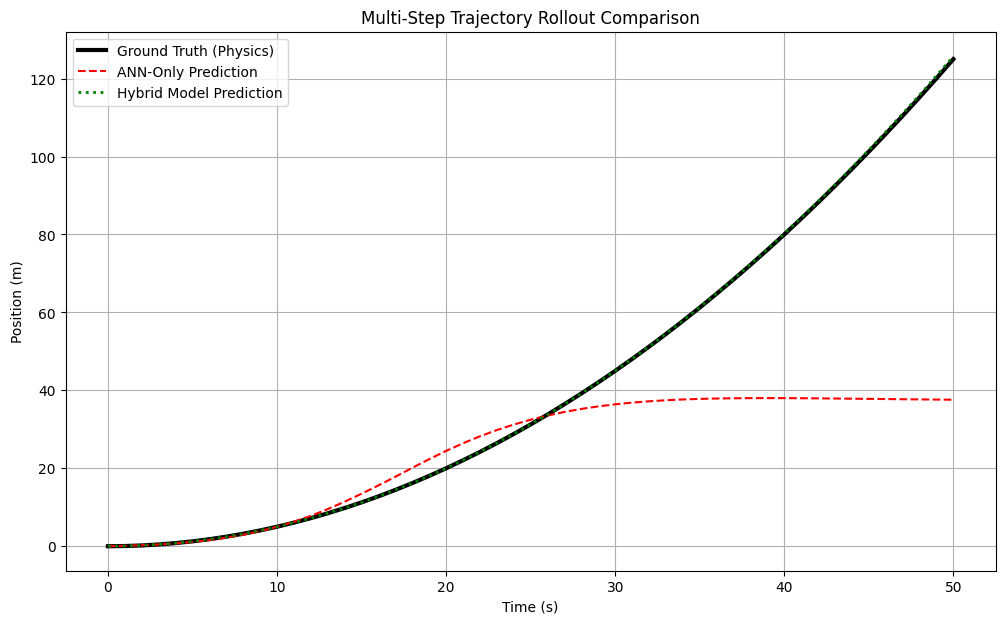


--- Multi-Step Rollout Evaluation (N=50 steps) ---
ANN-Only Model -> ADE: 19.2347 m, FDE: 87.4034 m
Hybrid Model   -> ADE: 0.1153 m, FDE: 0.7389 m


In [10]:
if __name__ == '__main__':
    # --- Data Preparation ---
    print("--- Generating Data ---")
    features, labels = generate_kinematic_data(Config.NUM_SAMPLES)
    dataset = KinematicsDataset(features, labels)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    print(f"Dataset created with {len(train_dataset)} training samples and {test_size} test samples.")

    # --- Model Initialization ---
    ann_only_model = ANNOnlyModel(Config.INPUT_SIZE, Config.HIDDEN_SIZE, Config.OUTPUT_SIZE, Config.NUM_HIDDEN_LAYERS)
    hybrid_model = HybridModel(Config.INPUT_SIZE, Config.HIDDEN_SIZE, Config.OUTPUT_SIZE, Config.NUM_HIDDEN_LAYERS)

    # --- Training ---
    ann_loss = train_model(ann_only_model, train_loader, Config.NUM_EPOCHS, Config.LEARNING_RATE, "ANN-Only Model")
    hybrid_loss = train_model(hybrid_model, train_loader, Config.NUM_EPOCHS, Config.LEARNING_RATE, "Hybrid Model")

    # --- Plot Training Loss ---
    plt.figure(figsize=(10, 5))
    plt.plot(ann_loss, label='ANN-Only Loss')
    plt.plot(hybrid_loss, label='Hybrid Model Loss')
    plt.title('Training Loss (MSE) vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.savefig('figure1.png') # Save figure for the paper
    plt.show()

    # --- Trajectory Rollout Simulation ---
    # Ground truth trajectory
    gt_inputs = torch.tensor([[Config.SIM_X0, Config.SIM_V0, Config.SIM_A, i * Config.SIM_DT] for i in range(Config.SIM_STEPS + 1)], dtype=torch.float32)
    gt_trajectory = physics_only_model(gt_inputs).numpy()

    # ANN-Only rollout
    ann_trajectory = rollout_trajectory(ann_only_model.to(device), Config.SIM_X0, Config.SIM_V0, Config.SIM_A, Config.SIM_DT, Config.SIM_STEPS, "ANN-Only Model")

    # Hybrid rollout
    hybrid_trajectory = rollout_trajectory(hybrid_model.to(device), Config.SIM_X0, Config.SIM_V0, Config.SIM_A, Config.SIM_DT, Config.SIM_STEPS, "Hybrid Model")

    # --- Plot Trajectory Results ---
    time_axis = np.arange(Config.SIM_STEPS + 1) * Config.SIM_DT

    plt.figure(figsize=(12, 7))
    plt.plot(time_axis, gt_trajectory[:, 0], 'k-', label='Ground Truth (Physics)', linewidth=3)
    plt.plot(time_axis, ann_trajectory[:, 0], 'r--', label='ANN-Only Prediction', markersize=4)
    plt.plot(time_axis, hybrid_trajectory[:, 0], 'g:', label='Hybrid Model Prediction', linewidth=2)

    plt.title('Multi-Step Trajectory Rollout Comparison')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.legend()
    plt.grid(True)
    plt.savefig('figure2.png') # Save figure for the paper
    plt.show()

    # --- Final Quantitative Evaluation (ADE/FDE) ---
    ade_ann = np.mean(np.abs(gt_trajectory[:, 0] - ann_trajectory[:, 0]))
    fde_ann = np.abs(gt_trajectory[-1, 0] - ann_trajectory[-1, 0])

    ade_hybrid = np.mean(np.abs(gt_trajectory[:, 0] - hybrid_trajectory[:, 0]))
    fde_hybrid = np.abs(gt_trajectory[-1, 0] - hybrid_trajectory[-1, 0])

    print("\n--- Multi-Step Rollout Evaluation (N=50 steps) ---")
    print(f"ANN-Only Model -> ADE: {ade_ann:.4f} m, FDE: {fde_ann:.4f} m")
    print(f"Hybrid Model   -> ADE: {ade_hybrid:.4f} m, FDE: {fde_hybrid:.4f} m")